# Importing Packages and Loading Datasets

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
#from statsmodels.tsa.arima_model import ARMA   # ARMA model has been deplicated
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

In [2]:
''' data directories '''

datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'

In [3]:
''' load datasets '''
UFO = pd.read_csv(os.path.join(datadir,'UFO.csv'))
DJI = pd.read_csv(os.path.join(datadir,'DJI.csv'))
MSFT = pd.read_csv(os.path.join(datadir,'MSFT.csv'), index_col='Date')
HRB = pd.read_csv(os.path.join(datadir,'HRB.csv'), index_col='Quarter')
AMZN = pd.read_csv(os.path.join(datadir,'AMZN.csv'), index_col='Date')
temp_NY = pd.read_csv(os.path.join(datadir,'NOAA_TAVG.csv'), index_col='DATE')

In [4]:
''' load datasets (read the generated datasets)'''
diet = pd.read_csv(os.path.join(datadir_pr,'diet_Google.csv'), index_col='Date')
stocks = pd.read_csv(os.path.join(datadir_pr,'stocks_US.csv'), index_col='observation_date')
bonds = pd.read_csv(os.path.join(datadir_pr,'bonds_US.csv'), index_col='observation_date')
x = pd.read_csv(os.path.join(datadir_pr,'Rsq_x.csv'), header=None).loc[:,1].rename('x')
y = pd.read_csv(os.path.join(datadir_pr,'Rsq_y.csv'), header=None).loc[:,1].rename('y')
daily_rates = pd.read_csv(os.path.join(datadir_pr,'daily_rates_1962.csv'), index_col='DATE')
intraday = pd.read_csv(os.path.join(datadir_pr,'intraday.csv'), index_col=0)
HO = pd.read_csv(os.path.join(datadir_pr,'HeatingOil.csv'), index_col='Date', parse_dates=True)
NG = pd.read_csv(os.path.join(datadir_pr,'NaturalGas.csv'), index_col='Date', parse_dates=True)
BTC = pd.read_csv(os.path.join(datadir_pr,'BitCoin.csv'), index_col='Date', parse_dates=True)
ETH = pd.read_csv(os.path.join(datadir_pr,'Ethereum.csv'), index_col='Date', parse_dates=True)

# Correlation and AutoCorrelation

In [5]:
print(len(diet))
diet.head()

261


,diet
Date,
6/26/2011,70
7/3/2011,71
7/10/2011,73
7/17/2011,74
7/24/2011,72


<AxesSubplot:xlabel='Date'>

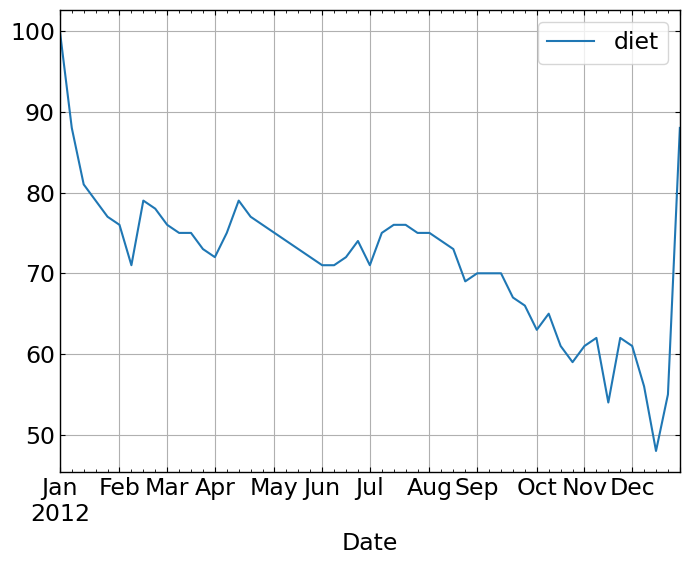

In [6]:
from matplotlib.dates import DateFormatter

# Convert the date index to datetime
diet.index = pd.to_datetime(diet.index)

# Slice the dataset to keep only 2012
diet2012 = diet[(diet.index>='2012') & (diet.index<'2013') ]

# Plot 2012 data

#fig, ax = plt.subplots()
#ax = sns.lineplot(x=diet2012.index.month, y=diet2012.diet, data=diet2012)
diet2012.plot(grid=True)

# Define the date format
#date_form = DateFormatter("%m")
#ax.xaxis.set_major_formatter(date_form)

### Merging time series w/ Different Dates

Stock and bond markets in the U.S. are closed on different days. For example, although the bond market is closed on Columbus Day (around Oct 12) and Veterans Day (around Nov 11), the stock market is open on those days. One way to see the dates that the stock market is open and the bond market is closed is to convert both indexes of dates into sets and take the difference in sets.

In [7]:
stocks.head()

,SP500
observation_date,
2007-06-11,1509.12
2007-06-12,1493.00
2007-06-13,1515.67
2007-06-14,1522.97
2007-06-15,1532.91


In [8]:
bonds.head()

,US10Y
observation_date,
2007-06-08,5.12
2007-06-11,5.14
2007-06-12,5.26
2007-06-13,5.20
2007-06-14,5.23


In [9]:
# Convert the stock index and bond index into sets
set_stock_dates = set(stocks.index)
set_bond_dates = set(bonds.index)

# Take the difference between the sets and print
print(set_stock_dates - set_bond_dates)

# Merge stocks and bonds DataFrames using join()
stocks_and_bonds = stocks.join(bonds, how='inner')

{'2009-10-12', '2013-10-14', '2011-10-10', '2007-10-08', '2009-11-11', '2015-10-12', '2011-11-11', '2010-11-11', '2007-11-12', '2016-10-10', '2012-11-12', '2016-11-11', '2010-10-11', '2013-11-11', '2014-11-11', '2008-11-11', '2015-11-11', '2008-10-13', '2012-10-08', '2017-06-09', '2014-10-13'}


### whether stocks are positively or negatively correlated with bonds.

Correlation of stocks and interest rates:  0.4119448886249271


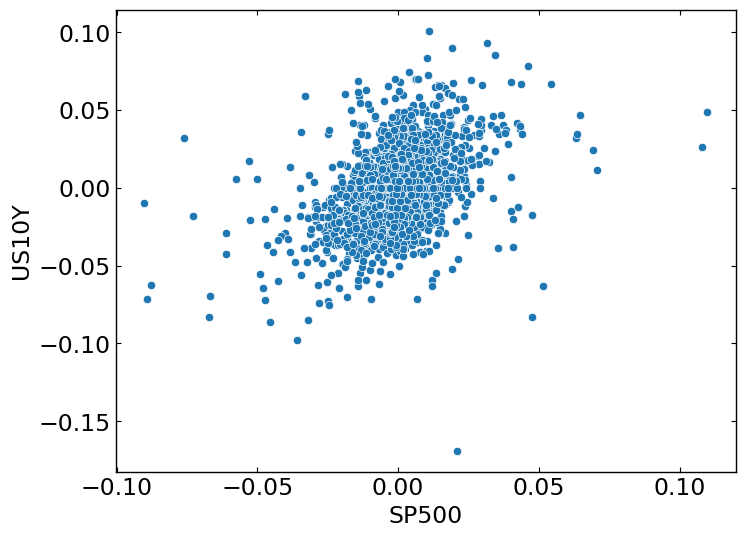

In [10]:
# Compute percent change using pct_change()
returns = stocks_and_bonds.pct_change()

# Compute correlation using corr()
correlation = returns.SP500.corr(returns.US10Y)
print("Correlation of stocks and interest rates: ", correlation)

# Make scatter plot
sns.scatterplot(x='SP500', y='US10Y', data=returns);

### Flying Saucers Aren't Correlated to Flying Markets

Two trending series may show a strong correlation even if they are completely unrelated. This is referred to as **"spurious correlation".**

In [11]:
''' dataframe merge '''
levels = UFO.merge(DJI, on='Date', suffixes=('_UFO','_DJI'))
levels.rename(columns={'Value_UFO':'UFO', 'Value_DJI':'DJI'}, inplace=True)
levels.set_index('Date', inplace=True)
levels.head()

,UFO,DJI
Date,,
1941,1,110.96
1942,2,119.40
1943,9,135.89
1944,9,152.32
1945,9,192.91


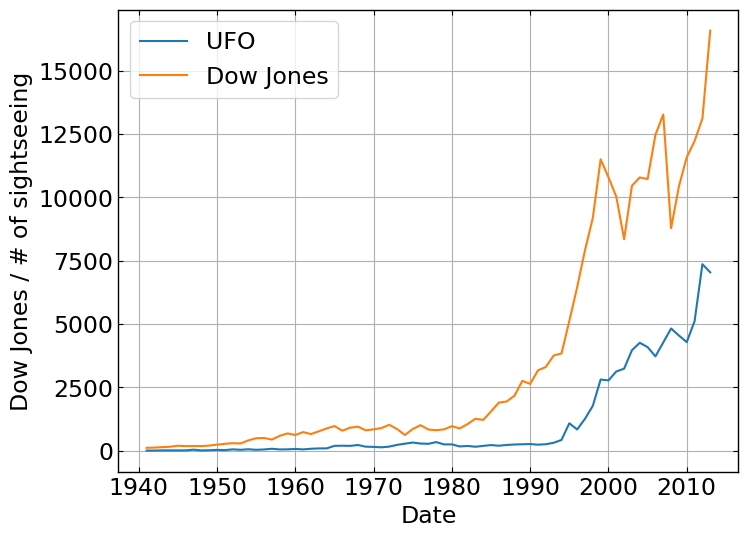

In [12]:
ax = levels.plot(grid=True)
ax.set_ylabel('Dow Jones / # of sightseeing')
ax.legend(labels=['UFO','Dow Jones']);

In [13]:
# Compute correlation of levels
correlation1 = levels.DJI.corr(levels.UFO)
print("Correlation of levels: ", correlation1)

# Compute correlation of percent changes
changes = levels.pct_change()
correlation2 = changes.DJI.corr(changes.UFO)
print("Correlation of changes: ", correlation2)

Correlation of levels:  0.9399762210726432
Correlation of changes:  0.06026935462405376


R-squared measures how closely the data fit the regression line, so the R-squared in a simple regression is related to the correlation between the two variables. In particular, the magnitude of the correlation is the square root of the R-squared and the sign of the correlation is the sign of the regression coefficient.

In [14]:
x.head()

0    1.281155
1   -0.612631
2    0.933222
3    2.269327
4   -1.427691
Name: x, dtype: float64

In [15]:
# Compute correlation of x and y
correlation = x.corr(y)
print("The correlation between x and y is %4.2f" %(correlation))

# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(x, columns=['x'])

# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)

# Regress y on dfx1
result = sm.OLS(y, dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())

The correlation between x and y is -0.90
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     4471.
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        03:14:53   Log-Likelihood:                -560.10
No. Observations:                1000   AIC:                             1124.
Df Residuals:                     998   BIC:                             1134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

# Some simple time series

## A Popular Strategy Using Autocorrelation

One puzzling anomaly with stocks is that investors tend to overreact to news. Following large jumps, either up or down, stock prices tend to reverse. This is described as mean reversion in stock prices: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. A more mathematical way to describe mean reversion is to say that stock returns are negatively autocorrelated.

In [16]:
MSFT.head()

,Adj Close
Date,
8/6/2012,26.107651
8/7/2012,26.377876
8/8/2012,26.438896
8/9/2012,26.587088
8/10/2012,26.517351


In [17]:
MSFT.index = pd.to_datetime(MSFT.index)

In [18]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-08-06 to 2017-08-04
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [19]:
# Convert the daily data to weekly data
#MSFT_res = MSFT.resample('W', how='last')  # keyword 'how' is deprecated, and resampler no longer dumps the data as DataFrame.
MSFT_res = MSFT.resample('W').last()   # or it can be .agg('last')
# Compute the percentage change of prices
returns = MSFT_res.pct_change()

# Compute and print the autocorrelation of returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is -0.16


That autocorrelation seems large, but is it statistically significant? In other words, can you say that there is less than a 5% chance that we would observe such a large negative autocorrelation if the true autocorrelation were really zero? And are there any autocorrelations at other lags that are significantly different from zero?

> In fact, the standard deviation of the sample autocorrelation is $1/\sqrt{N}$ where $N$ is the number of observations, so if $N=100$, for example, the standard deviation of the ACF is 0.1, and since 95\% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is $\pm 1.96/\sqrt{N}$. This approximation only holds when the true autocorrelations are all zero.

The autocorrelation of weekly MSFT returns is -0.16
The approximate confidence interval is +/- 0.12


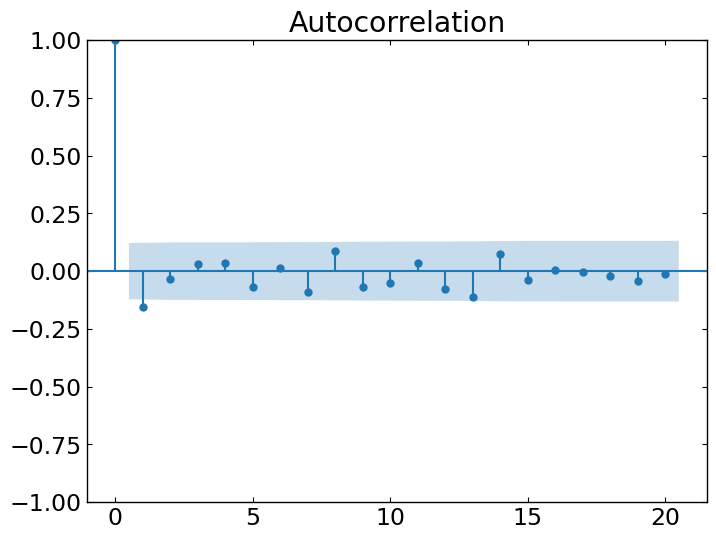

In [20]:
# Compute and print the autocorrelation of MSFT weekly returns
print("The autocorrelation of weekly MSFT returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(returns)

# Compute the approximate confidence interval
conf = 1.96/np.sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(returns.dropna(), alpha=0.05, lags=20);  # note that it should drop the nan values in returns dataset

## Are Interest Rates Autocorrelated?

When you look at daily changes in interest rates, the autocorrelation is close to zero. However, if you resample the data and look at annual changes, the autocorrelation is negative. This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated. A daily move up or down in interest rates is unlikely to tell you anything about interest rates tomorrow, but a move in interest rates over a year can tell you something about where interest rates are going over the next year. And this makes some economic sense: over long horizons, when interest rates go up, the economy tends to slow down, which consequently causes interest rates to fall, and vice versa.

In [21]:
daily_rates.head()

,US10Y
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [22]:
daily_rates.index = pd.to_datetime(daily_rates.index)

In [23]:
daily_rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13853 entries, 1962-01-02 to 2017-06-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   US10Y   13853 non-null  float64
dtypes: float64(1)
memory usage: 216.5 KB


In [24]:
# Compute the daily change in interest rates 
daily_diff = daily_rates.diff()

# Compute and print the autocorrelation of daily changes
autocorrelation_daily = daily_diff['US10Y'].autocorr()
print("The autocorrelation of daily interest rate changes is %4.2f" %(autocorrelation_daily))

# Convert the daily data to annual data
yearly_rates = daily_rates.resample(rule='A').last()

# Repeat above for annual data
yearly_diff = yearly_rates.diff()
autocorrelation_yearly = yearly_diff['US10Y'].autocorr()
print("The autocorrelation of annual interest rate changes is %4.2f" %(autocorrelation_yearly))

The autocorrelation of daily interest rate changes is 0.07
The autocorrelation of annual interest rate changes is -0.22


In [25]:
yearly_rates.head()

,US10Y
DATE,
1962-12-31,3.85
1963-12-31,4.14
1964-12-31,4.21
1965-12-31,4.65
1966-12-31,4.64


## Taxing Exercise: Compute the ACF

Often we are interested in seeing the autocorrelation over many lags. The quarterly earnings for H&R Block (ticker symbol HRB) is plotted on the right, and you can see the extreme cyclicality of its earnings. A vast majority of its earnings occurs in the quarter that taxes are due.

In [26]:
HRB.head()

,Earnings
Quarter,
2007Q1,-0.36
2007Q2,-0.38
2007Q3,0.07
2007Q4,1.85
2008Q1,-0.34


In [27]:
HRB.index = pd.to_datetime(HRB.index)

In [28]:
HRB.head()

,Earnings
Quarter,
2007-01-01,-0.36
2007-04-01,-0.38
2007-07-01,0.07
2007-10-01,1.85
2008-01-01,-0.34


[ 1.         -0.22122696 -0.39856504 -0.26615093  0.83479804 -0.1901038
 -0.3475634  -0.23140368  0.71995993 -0.15661007 -0.29766783 -0.22097189
  0.61656933 -0.15022869 -0.27922022 -0.22465946  0.5725259 ]


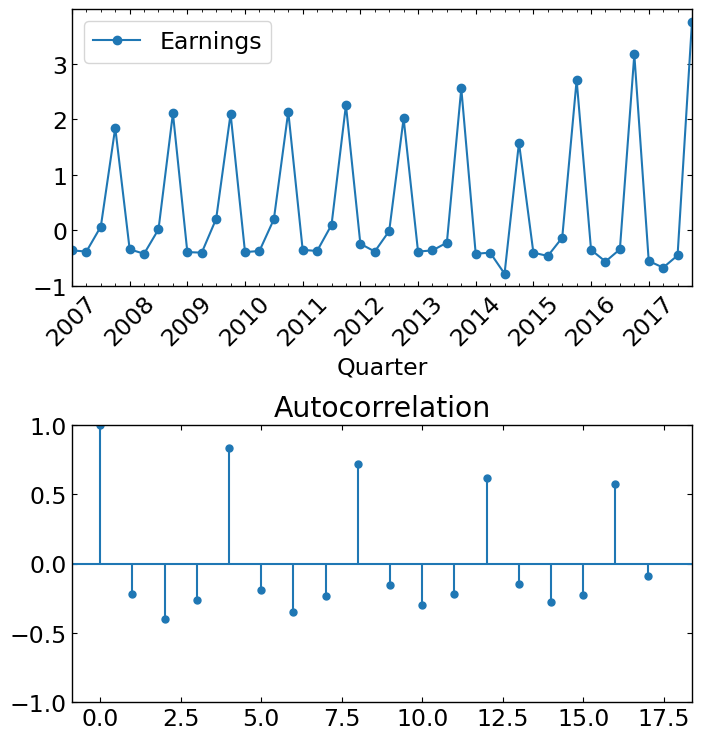

In [29]:
fig, axes = plt.subplots(2,1, figsize=(8,9))
HRB.plot(linestyle='-', marker='o',ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)

# Compute the acf array of HRB
acf_array = acf(HRB.Earnings)
print(acf_array)

# Plot the acf function
plot_acf(HRB, alpha=1, ax=axes[1])

# adjust the space between the subplots
plt.subplots_adjust(hspace=0.5);

## White Noise

A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

The mean is 0.018 and the standard deviation is 0.050


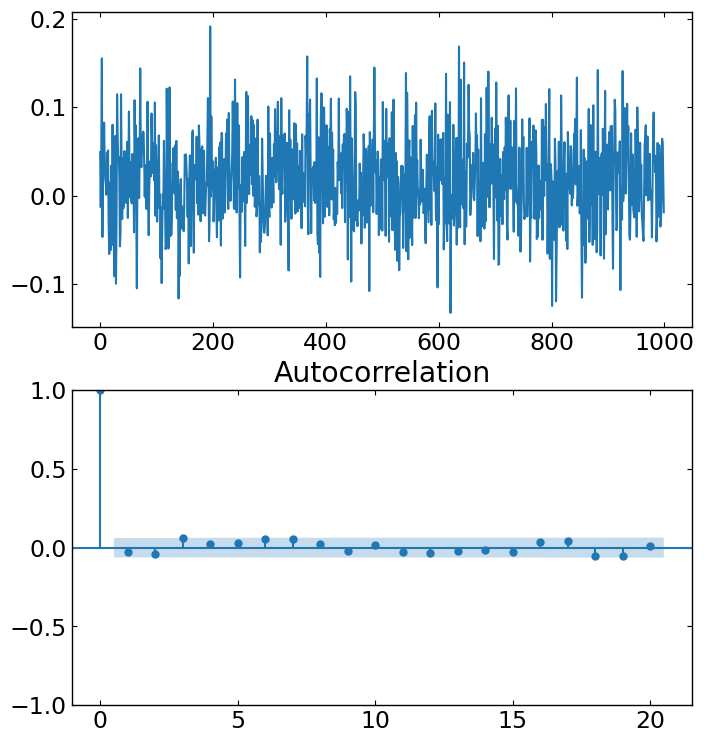

In [30]:
# Simulate white noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

fig, axes = plt.subplots(2,1, figsize=(8,9))
# Plot returns series
axes[0].plot(returns)

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20, ax=axes[1]);

## Random Walk

Whereas stock returns are often modeled as white noise, stock prices closely follow a random walk. In other words, today's price is yesterday's price plus some random noise.

Text(0.5, 1.0, 'Simulated Random Walk')

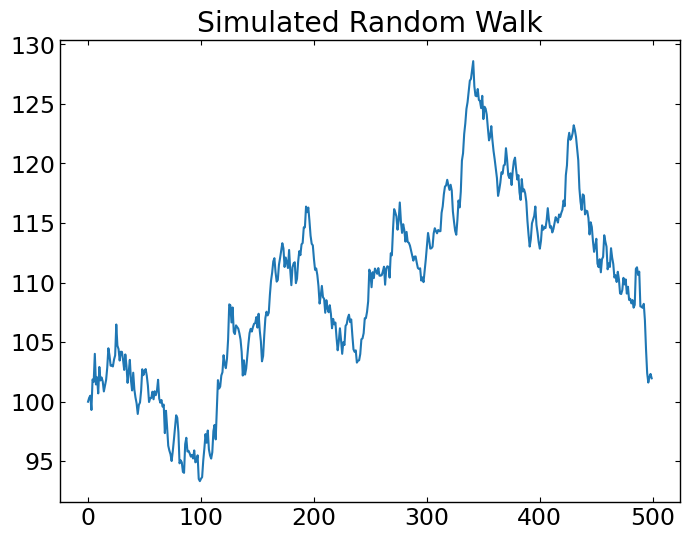

In [31]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1, size=500)

# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0

# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)

# Plot the simulated stock prices
fig, ax = plt.subplots()
ax.plot(P)
ax.set_title("Simulated Random Walk")

- random walk with a drift. Many time series, like stock prices, are random walks but tend to drift up over time.
- when adding noise, you could theoretically get negative prices. Now you will make the noise multiplicative: you will add one to the random, normal changes to get a total return, and multiply that by the last price.

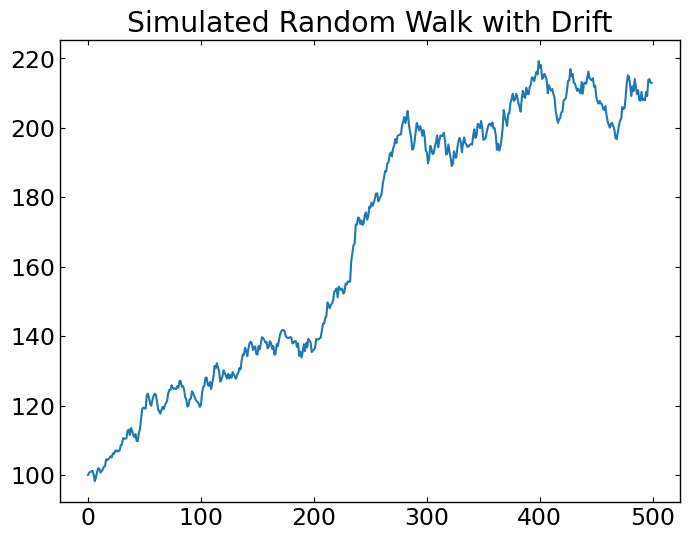

In [32]:
# Generate 500 random steps
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
fig, ax = plt.subplots()
ax.plot(P)
ax.set_title("Simulated Random Walk with Drift");

## Augumented Dickey-Fuller Test

Most stock prices follow a random walk (perhaps with a drift). You will look at a time series of Amazon stock prices, pre-loaded in the DataFrame AMZN, and run the 'Augmented Dickey-Fuller Test' from the statsmodels library to show that it does indeed follow a random walk.

In [33]:
AMZN.index = pd.to_datetime(AMZN.index)

In [34]:
AMZN.head()

,Adj Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


In [35]:
# Run the ADF test on the price series and print out the results
results = adfuller(AMZN['Adj Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(4.025168525770736, 1.0, 33, 5054, {'1%': -3.4316445438146865, '5%': -2.862112049726916, '10%': -2.5670745025321304}, 30308.64216426981)
The p-value of the test on prices is: 1.0


In [36]:
# Create a DataFrame of AMZN returns
AMZN_ret = AMZN.pct_change()

# Eliminate the NaN in the first row of returns
AMZN_ret = AMZN_ret.dropna()

# Run the ADF test on the return series and print out the p-value
results = adfuller(AMZN_ret['Adj Close'])
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 2.5655898083485823e-22


> Returns shows that it do not follow a random walk

## Stationarity

Many time series exhibit strong seasonal behavior. The procedure for removing the seasonal component of a time series is called seasonal adjustment. For example, most economic data published by the government is seasonally adjusted.

You saw earlier that by taking first differences of a random walk, you get a stationary white noise process. For seasonal adjustments, instead of taking first differences, you will take differences with a lag corresponding to the periodicity.

            Earnings
Quarter             
2007-01-01       NaN
2007-04-01       NaN
2007-07-01       NaN
2007-10-01       NaN
2008-01-01      0.02
2008-04-01     -0.04
2008-07-01     -0.05
2008-10-01      0.26
2009-01-01     -0.05
2009-04-01      0.02


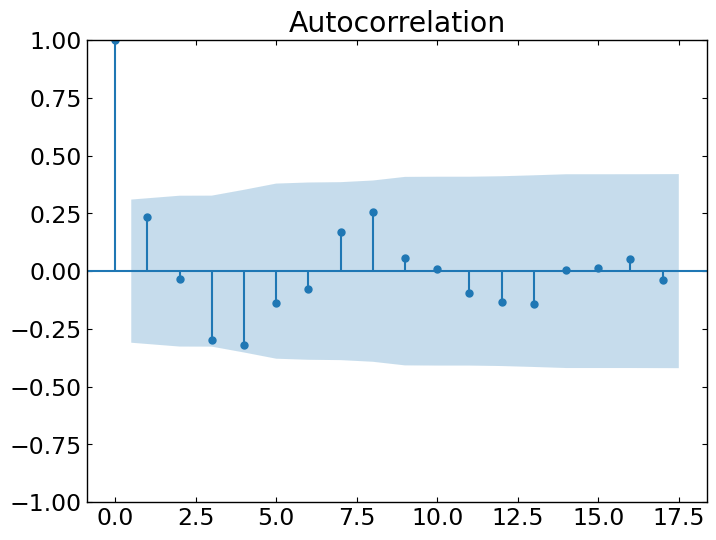

In [37]:
# Seasonally adjust quarterly earnings
HRBsa = HRB.diff(4)

# Print the first 10 rows of the seasonally adjusted series
print(HRBsa.head(10))

# Drop the NaN data in the first four rows
HRBsa = HRBsa.dropna()

# Plot the autocorrelation function of the seasonally adjusted series
plot_acf(HRBsa);

# Autoregressive (AR) Models

You will simulate and plot a few AR(1) time series, each with a different parameter, $\phi$, using the `arima_process` module in statsmodels. In this exercise, you will look at an AR(1) model with a large positive $\phi$ and a large negative $\phi$, but feel free to play around with your own parameters.

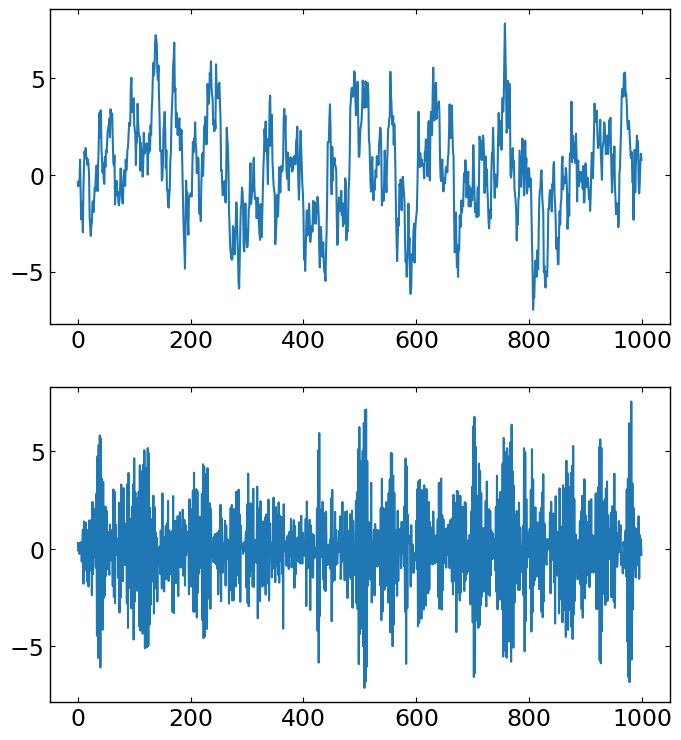

In [38]:
fig, axes = plt.subplots(2,1,figsize=(8,9))
# Plot 1: AR parameter = +0.9
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
axes[0].plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
axes[1].plot(simulated_data_2);

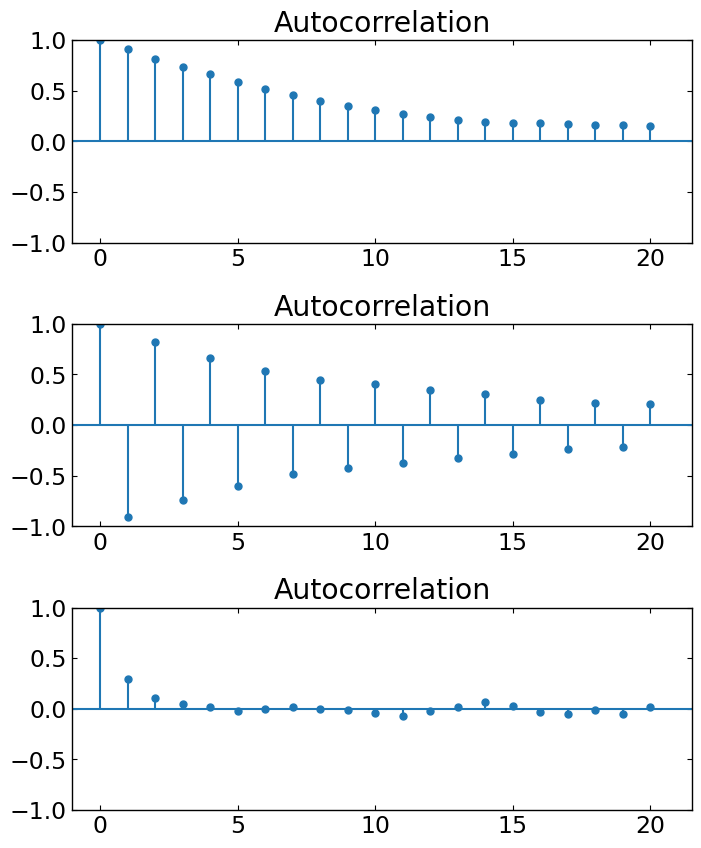

In [39]:
fig, axes = plt.subplots(3,1,figsize=(8,10))
# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20, ax=axes[0])

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20, ax=axes[1])

# Plot 3: AR parameter = +0.3
ar3 = np.array([1, -0.3])
ma3 = np.array([1])
AR_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = AR_object3.generate_sample(nsample=1000)
plot_acf(simulated_data_3, alpha=1, lags=20, ax=axes[2])

plt.subplots_adjust(hspace=0.4);

## Forecasting AR Model

In [40]:
# Fit an AR(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(1,0,0))    # order (1,0,0): AR(1), (2,0,0): AR(2) / note that ARMA model has been deprecated
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print("When the true phi=0.9, the estimate of phi (and the constant) are:")
print(res.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1465.341
Date:                Wed, 21 Sep 2022   AIC                           2936.682
Time:                        03:14:55   BIC                           2951.405
Sample:                             0   HQIC                          2942.278
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2232      0.357      0.625      0.532      -0.476       0.923
ar.L1          0.9072      0.013     67.948      0.000       0.881       0.933
sigma2         1.0953      0.049     22.479      0.0

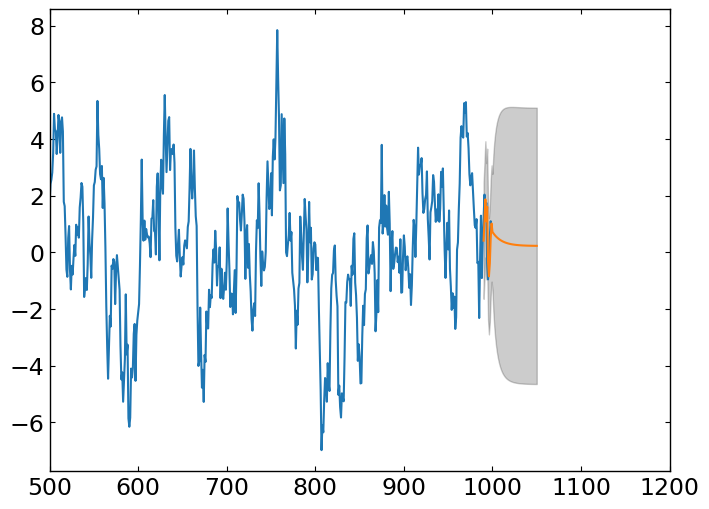

In [41]:
# Forecast the first AR(1) model
mod = ARIMA(simulated_data_1, order=(1,0,0))
res = mod.fit()

fig, ax = plt.subplots()

ax.plot(simulated_data_1)
#res.plot_predict(start=990, end=1010)  # ARIMAResults.plot_predict() has been deprecated

# alternative way to draw prediction with confidence interval
pred_xind0 = 990
pred_xind1 = 1050
pred_x = np.arange(pred_xind0,pred_xind1+1)
predict = res.get_prediction(start=pred_xind0, end=pred_xind1)
predict_ci = predict.conf_int()   # confidence interval
#plot_predict(res, start=pred_xind0, end=pred_xind1, ax=ax);
ax.plot(pred_x, predict.predicted_mean)
ax.fill_between(pred_x, predict_ci[:,0], predict_ci[:,1], color='k', alpha=0.2)

ax.set_xlim(500,1200);

In [42]:
interest_rate_data = yearly_rates.copy() # see above in chapter 1

interest_rate_data.head()

,US10Y
DATE,
1962-12-31,3.85
1963-12-31,4.14
1964-12-31,4.21
1965-12-31,4.65
1966-12-31,4.64


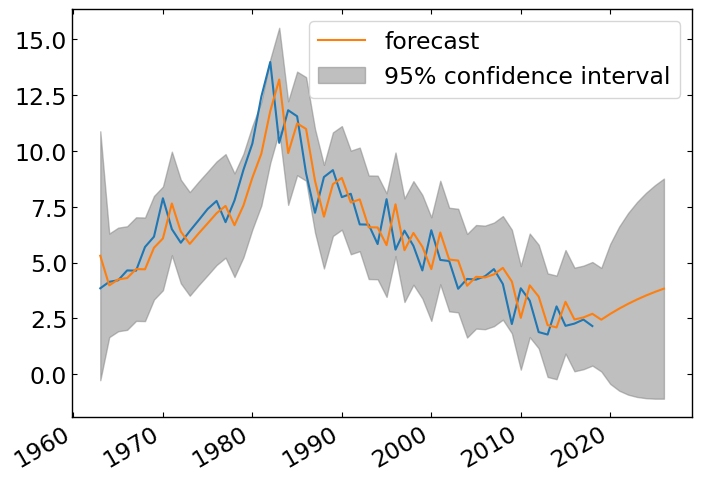

In [43]:
# Forecast interest rates using an AR(1) model
mod = ARIMA(interest_rate_data, order=(1,0,0))
res = mod.fit()

fig, ax = plt.subplots()

ax.plot(interest_rate_data.index, interest_rate_data.US10Y)
# Plot the original series and the forecasted series
#res.plot_predict(start=0, end='2022')

plot_predict(res, start=0, end='2025', ax=ax);

## Compare AR Model w/ Random Walk

Sometimes it is difficult to distinguish between a time series that is slightly mean reverting and a time series that does not mean revert at all, like a random walk. You will compare the ACF for the slightly mean-reverting interest rate series of the last exercise with a simulated random walk with the same number of observations.

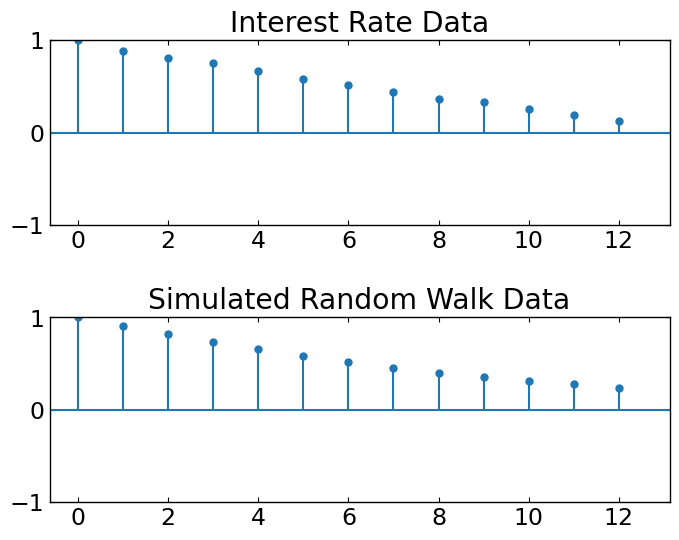

In [44]:
# Plot the interest rate series and the simulated random walk series side-by-side
fig, axes = plt.subplots(2,1)

# Plot the autocorrelation of the interest rate series in the top plot
plot_acf(interest_rate_data, alpha=1, lags=12, ax=axes[0])

# Plot the autocorrelation of the simulated random walk series in the bottom plot
plot_acf(simulated_data_1, alpha=1, lags=12, ax=axes[1])

# Label axes
axes[0].set_title("Interest Rate Data")
axes[1].set_title("Simulated Random Walk Data")

plt.subplots_adjust(hspace=0.5);

## Estimate Order of Model: PACF

One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). In this exercise, you will simulate two time series, an AR(1) and an AR(2), and calculate the sample PACF for each. You will notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the sample PACF should have significant lag-1 and lag-2 values, and zeros after that.

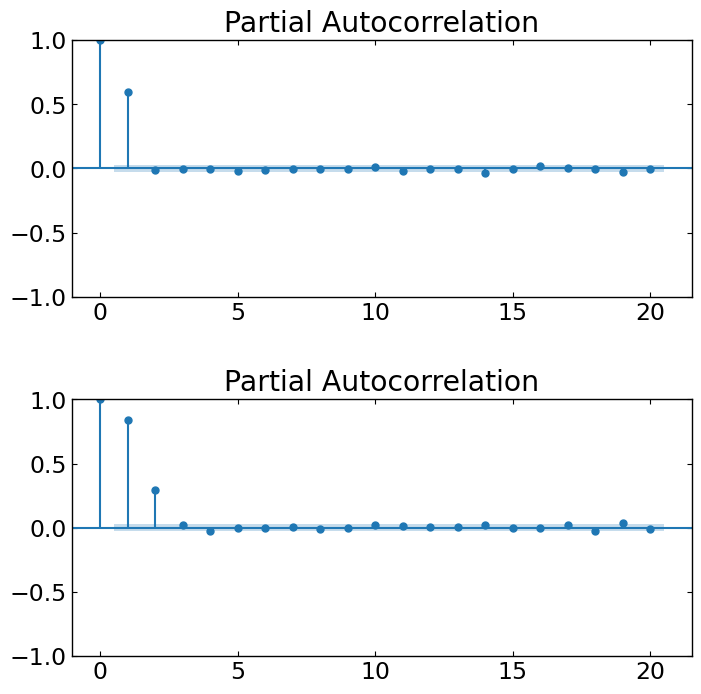

In [45]:
# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

fig, axes = plt.subplots(2,1,figsize=(8,8))
# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20, ax=axes[0], method='ywm')

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20, ax=axes[1], method='ywm')

plt.subplots_adjust(hspace=0.4);

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. You will take the AR(2) simulated data from the last exercise, saved as simulated_data_2, and compute the BIC as you vary the order, p, in an AR(p) from 0 to 6.

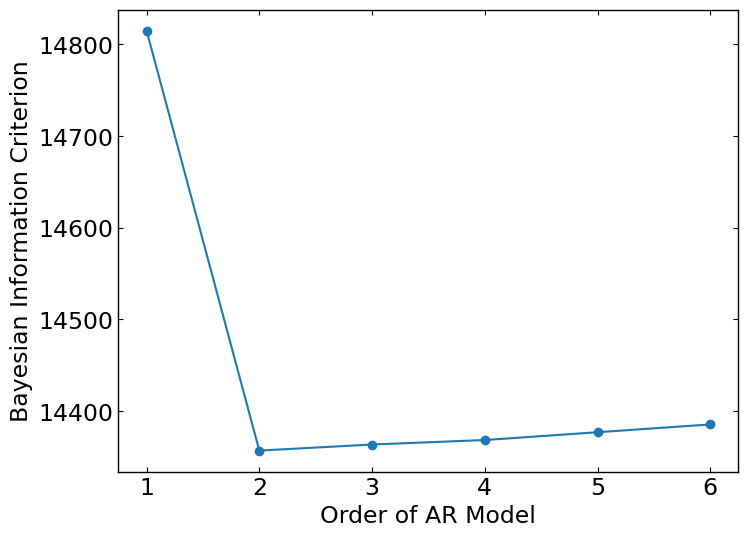

In [46]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(simulated_data_2, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
  
fig, ax = plt.subplots()

# Plot the BIC as a function of p
ax.plot(range(1,7), BIC[1:7], marker='o')
ax.set_xlabel('Order of AR Model')
ax.set_ylabel('Bayesian Information Criterion');

# Moving Average (MA) AND ARMA Models

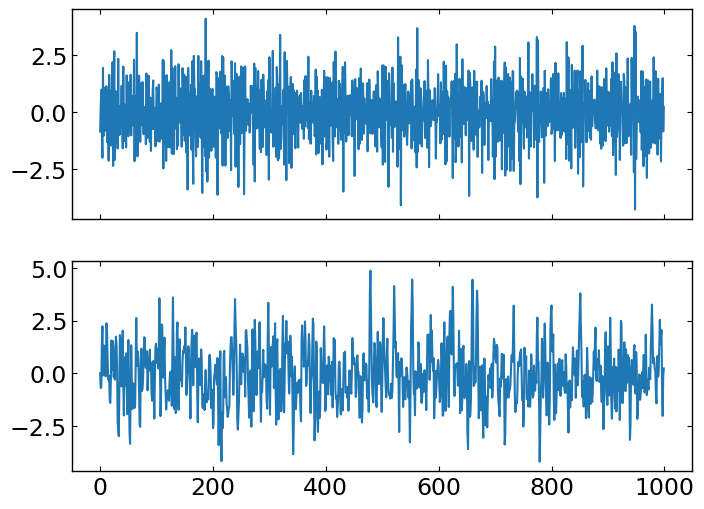

In [47]:
# Plot 1: MA parameter = -0.9
fig, axes = plt.subplots(2,1, sharex=True)

ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
axes[0].plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
axes[1].plot(simulated_data_2);

> - Unlike an AR(1), an MA(1) model has no autocorrelation beyond lag 1, an MA(2) model has no autocorrelation beyond lag 2, etc. 
> - The lag-1 autocorrelation for an MA(1) model is not $\theta$, but rather $\theta/(1+\theta^2)$.

In [48]:
ar3 = np.array([1])
ma3 = np.array([1, -0.3])
MA_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = MA_object3.generate_sample(nsample=1000)

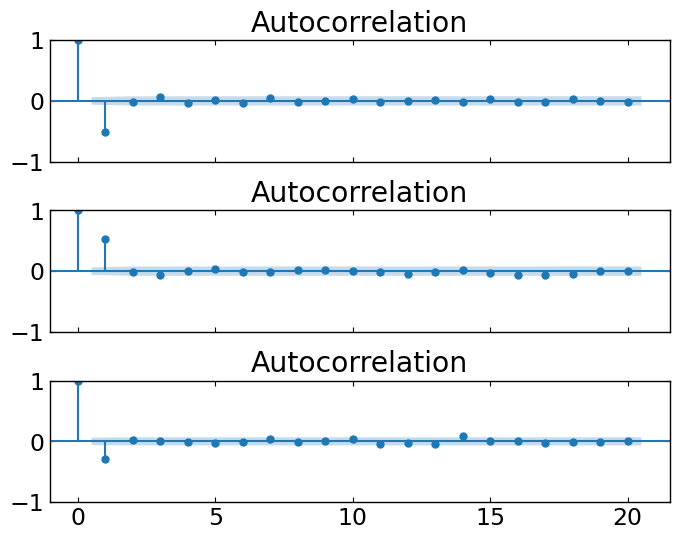

In [49]:
fig, axes = plt.subplots(3,1, sharex=True)
# Plot 1: MA parameter = -0.9
plot_acf(simulated_data_1, lags=20, ax=axes[0])

# Plot 2: MA parameter = 0.9
plot_acf(simulated_data_2, lags=20, ax=axes[1])

# Plot 3: MA parameter = -0.3
plot_acf(simulated_data_3, lags=20, ax=axes[2])

fig.subplots_adjust(hspace=0.4);

In [50]:
# Fit an MA(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta is:")
print(res.params[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1413.165
Date:                Wed, 21 Sep 2022   AIC                           2832.330
Time:                        03:15:01   BIC                           2847.053
Sample:                             0   HQIC                          2837.926
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -0.975      0.329      -0.010       0.003
ma.L1         -0.8954      0.015    -61.632      0.000      -0.924      -0.867
sigma2         0.9869      0.046     21.459      0.0

## Forecasting with MA Model

In [51]:
df_sim1 = pd.DataFrame(simulated_data_1, columns=['data'])

In [52]:
df_sim1.head()

,data
0,-0.851064
1,0.248236
2,0.983975
3,-0.837234
4,-1.996378


In [53]:
print(df_sim1.shape)

(1000, 1)


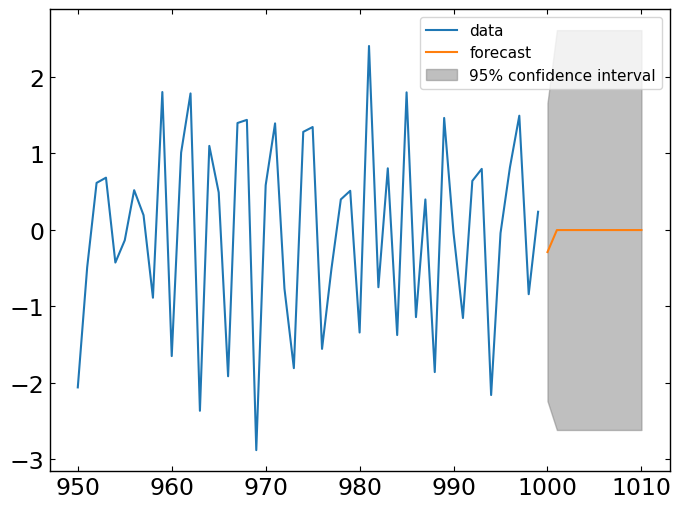

In [54]:
# Forecast the first MA(1) model
mod = ARIMA(df_sim1, order=(0,0,1))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
df_sim1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)

ax.legend(fontsize=11);

## ARMA Model

In [55]:
# Change the first date to zero
intraday.iloc[0,0] = 0

# Change the column headers to 'DATE' and 'CLOSE'
intraday.columns = ["DATE","CLOSE"]

# Examine the data types for each column
print(intraday.dtypes)

# Convert DATE column to numeric
intraday['DATE'] = pd.to_numeric(intraday['DATE'])

# Make the `DATE` column the new index
intraday.set_index('DATE',inplace=True)

intraday.head()

DATE      object
CLOSE    float64
dtype: object


,CLOSE
DATE,
0,8.2900
1,8.2700
2,8.2800
3,8.2750
4,8.2875


There will be missing data if there are no trades in a particular one-minute interval. One way to see which rows are missing is to take the difference of two sets: the full set of every minute and the set of the DataFrame index which contains missing rows. 

In [56]:
# Notice that some rows are missing
print("If there were no missing rows, there would be 391 rows of minute data")
print("The actual length of the DataFrame is:", len(intraday))

If there were no missing rows, there would be 391 rows of minute data
The actual length of the DataFrame is: 389


In [57]:
''' cleaning the missing data '''

# Everything
set_everything = set(range(391))

# The intraday index as a set
set_intraday = set(intraday.index)

# Calculate the difference
set_missing = set_everything - set_intraday

# Print the difference
print("Missing rows: ", set_missing)

Missing rows:  {182, 14}


In [58]:
# Fill in the missing rows
intraday = intraday.reindex(range(391), method='ffill')

# Change the index to the intraday times
intraday.index = pd.date_range(start='2017-09-01 9:30', end='2017-09-01 16:00', freq='1min')

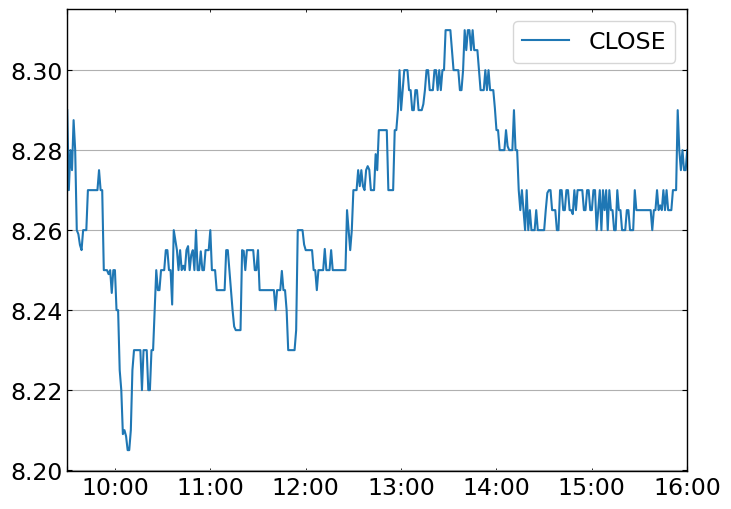

In [59]:
# Plot the intraday time series
intraday.plot(grid=True);

## Applying MA Model

- The bouncing of the stock price between bid and ask induces a negative first order autocorrelation, but no autocorrelations at lags higher than 1. 
- You get the same ACF pattern with an MA(1) model. 
- Therefore, you will fit an MA(1) model to the intraday stock data from the last exercise.

-0.171716193948006


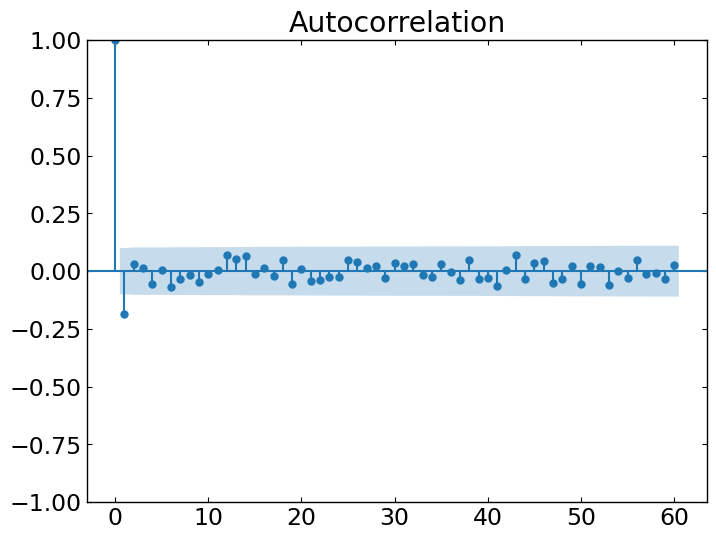

In [60]:
# Compute returns from prices and drop the NaN
returns = intraday.pct_change()
returns = returns.dropna()

# Plot ACF of returns with lags up to 60 minutes
plot_acf(returns, lags=60);

# Fit the data to an MA(1) model
mod = ARIMA(returns, order=(0,0,1))
res = mod.fit()
print(res.params[1])

## AR(1) and MA(infinity)

- AR(1) model is equivalent to an MA($\infty$) model with the appropriate parameters.
- For example, You will simulate an MA model with parameters $0.8, 0.8^2, 0.8^3, ...$

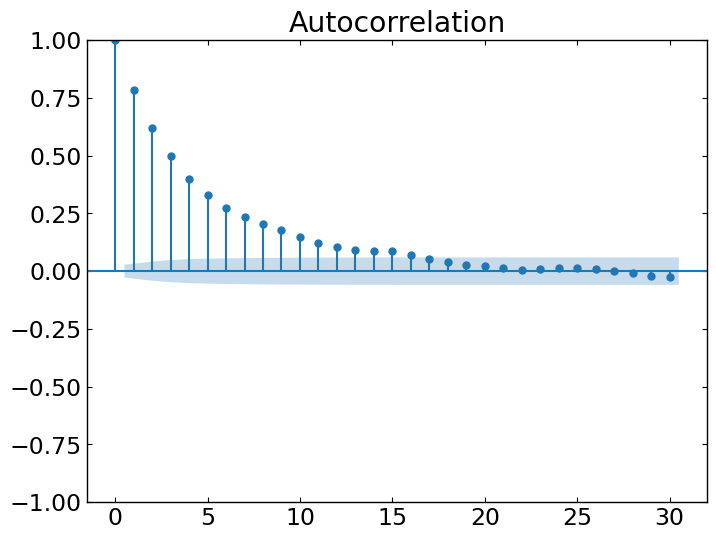

In [61]:
# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30);

# Putting it all together

## Cointegration Models

- Two series look like random walks. 
- Then plot the difference between the two series, which should look more like a mean reverting series
- to put the two series in the same units, we multiply the heating oil prices, in \\$/gallon, by 7.25, which converts it to \\$/millionBTU, which is the same units as Natural Gas.

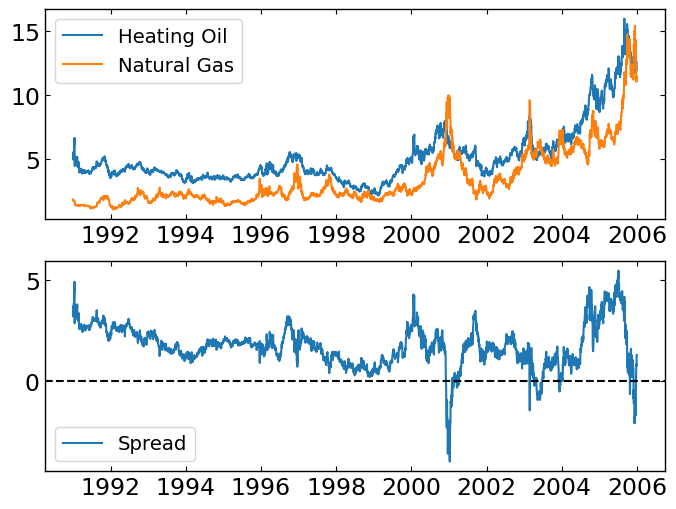

In [62]:
fig, axes = plt.subplots(2,1)
# Plot the prices separately
axes[0].plot(7.25*HO, label='Heating Oil')
axes[0].plot(NG, label='Natural Gas')
axes[0].legend(loc='best', fontsize='small')

# Plot the spread
axes[1].plot(7.25*HO-NG, label='Spread')
axes[1].legend(loc='best', fontsize='small')
axes[1].axhline(y=0, linestyle='--', color='k');

To verify that Heating Oil and Natural Gas prices are cointegrated, 
- First apply the `Dickey-Fuller test` separately to show they are random walks. 
- Then apply the test to the difference, which should strongly reject the random walk hypothesis. 

In [63]:
# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO - NG)
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.9567108785017862
The p-value for the ADF test on NG is  0.9008747444676726
The p-value for the ADF test on the spread is  7.019439302142247e-05


### Are Bitcoin and Ethereum Cointegrated?

Cointegration involves two steps: 
- regressing one time series on the other to get the cointegration vector,
- then perform an ADF test on the residuals of the regression.

In [64]:
# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b*ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.02336900232347285


## CASE Study: New York Temperate

- the average annual temperature in Central Park, NY from 1870-2016.

The p-value for the ADF test is  0.5832938987871106


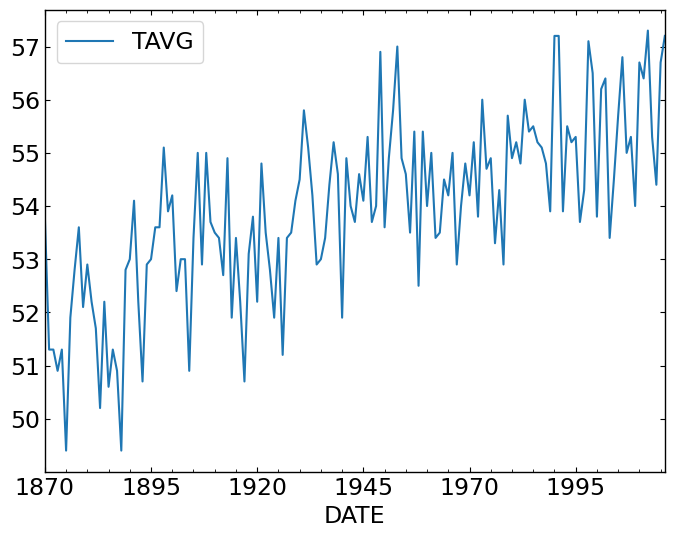

In [65]:
# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

- Since the temperature series, temp_NY, is a random walk with drift, take first differences to make it stationary. 
- Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

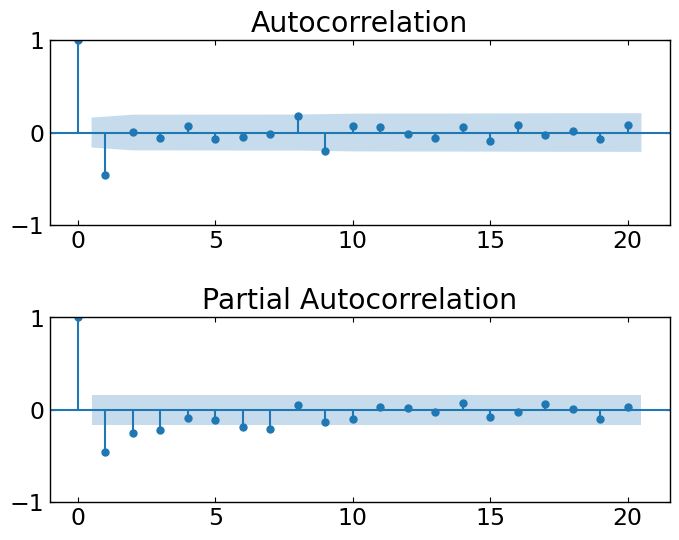

In [66]:
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1], method='ywm')

fig.subplots_adjust(hspace=0.5);

### Find the best model by using AIC

- the `Akaike Information Criterion (AIC)` can be used to compare models with different numbers of parameters. 
- It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. 
- Lower AIC scores are better.

In [67]:
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1, 0, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: Val

The AIC for an AR(1) is:  510.534689873311
The AIC for an AR(2) is:  501.92741234091386
The AIC for an ARMA(1,1) is:  469.07291881237757


- Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. 
- Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


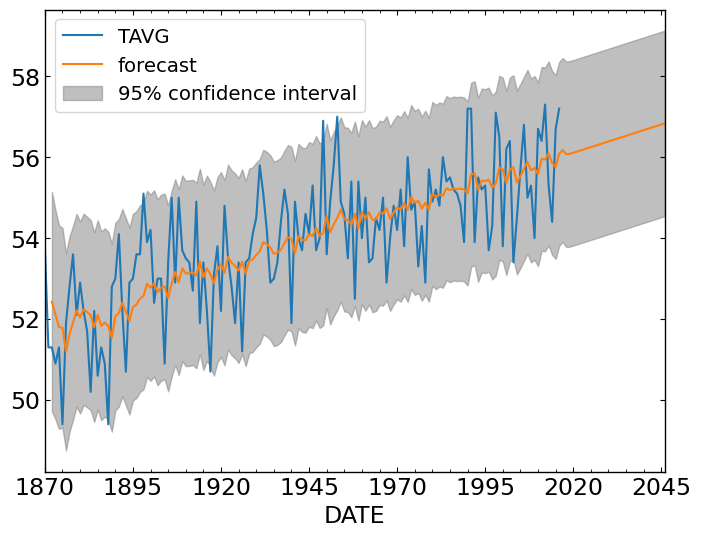

In [68]:
# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
ax.legend(fontsize='small');